# Чекпоинт 6 - DL-модели

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [10]:
file_url = "https://drive.google.com/uc?id=1Rn3-XWfgK-fs7-8G2HM9bkLQ9utTA4wJ"
data = pd.read_csv(file_url)
first_tier_tickers = ["PLZL", "SIBN", "NVTK", "LKOH", "SBER", "SBERP", "ROSN",  "GAZP", "TATN", "TATNP", "SNGS", "SNGSP", "CHMF", "NLMK"]
data = data[data['TICKER'].isin(first_tier_tickers)]
data['TRADEDATE'] = pd.to_datetime(data['TRADEDATE'])

In [34]:
data

,TRADEDATE,OPEN,HIGH,LOW,CLOSE,VOLUME,TICKER
0,2023-10-30,269.90,271.55,268.60,269.89,33345990,SBER
1,2023-10-31,270.00,270.50,266.87,268.35,26210450,SBER
2,2023-11-01,268.29,270.30,267.60,269.68,20609480,SBER
3,2023-11-02,270.00,270.98,268.50,269.06,25751530,SBER
4,2023-11-03,269.07,269.78,267.20,268.54,20981280,SBER
...,...,...,...,...,...,...,...
3933,2024-10-24,126.24,127.00,123.58,125.90,19463160,NLMK
3934,2024-10-25,125.90,126.50,117.90,121.14,27086890,NLMK
3935,2024-10-28,120.00,120.00,115.40,117.22,15614300,NLMK
3936,2024-10-29,117.22,121.76,115.72,121.28,15422580,NLMK


## LSTM + GRU

In [15]:
def set_random_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

In [16]:
def prepare_data(arr, window):
    X, y = [], []
    for i in range(len(arr) - window):
        X.append(arr[i:i + window])
        y.append(arr[i + window])
    return np.array(X), np.array(y)


In [17]:
def fill_missing_data(ticker_data):
    ticker_data['CLOSE'] = ticker_data['CLOSE'].fillna(method='ffill')
    # ticker_data['CLOSE'] = ticker_data['CLOSE'].fillna(ticker_data['CLOSE'].mean())
    return ticker_data

In [18]:
def fit_once_lstm(ticker_data, window=20, future_forecast_days=30, epochs=100, batch_size=32, verbose=0, noise_scale=0.5):
    ticker_data = ticker_data.sort_values('TRADEDATE')
    ticker_data = fill_missing_data(ticker_data)

    values = ticker_data['CLOSE'].values.reshape(-1, 1)
    dates = ticker_data['TRADEDATE'].values

    scaler = MinMaxScaler()
    values_scaled = scaler.fit_transform(values)

    X, y = prepare_data(values_scaled, window)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    split = int(len(X) * 0.8)
    X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(window, 1)),
        Dropout(0.2),
        GRU(64, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss=tf.keras.losses.Huber())

    es = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,
              verbose=verbose, callbacks=[es])

    preds_scaled = model.predict(X_test, verbose=0)
    residuals = y_test.flatten() - scaler.inverse_transform(preds_scaled).flatten()
    residual_std = np.std(residuals)

    preds_with_noise = scaler.inverse_transform(preds_scaled) + np.random.normal(loc=0, scale=residual_std * noise_scale, size=preds_scaled.shape)
    y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_real, preds_with_noise)
    mae = mean_absolute_error(y_test_real, preds_with_noise)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test_real, preds_with_noise)
    r2 = r2_score(y_test_real, preds_with_noise)

    last_window = values_scaled[-window:].reshape(1, window, 1)
    future_forecast = []
    for _ in range(future_forecast_days):
        next_scaled = model.predict(last_window, verbose=0)[0][0]
        next_price = scaler.inverse_transform([[next_scaled]])[0][0]

        noise = np.random.normal(loc=0, scale=residual_std * noise_scale)
        next_price_with_noise = next_price + noise

        future_forecast.append(next_price_with_noise)
        last_window = np.append(last_window[:, 1:, :], [[[next_scaled]]], axis=1)

    future_dates = pd.date_range(dates[-1], periods=future_forecast_days + 1, freq='B')[1:]

    plt.figure(figsize=(16, 5))
    plt.plot(dates, values.flatten(), label='фактическая цена')
    plt.plot(dates[split + window:], preds_with_noise.flatten(), label='Прогноз на тесте')
    plt.plot(future_dates, future_forecast, '--', label='Прогноз на будущее')
    plt.title(f'LSTM-GRU модель ({ticker_data["TICKER"].iloc[0]})  MAE={mae:.2f}')
    plt.xlabel('дата')
    plt.ylabel('цена закрытия')
    plt.legend()
    plt.grid(True)
    plt.show()

    tf.keras.backend.clear_session()
    print(f'{ticker_data["TICKER"].iloc[0]}: "MSE":{mse},"MAE":{mae},"RMSE":{rmse},"MAPE":{mape},"R2":{r2}')
    return {"MSE": mse, "MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}

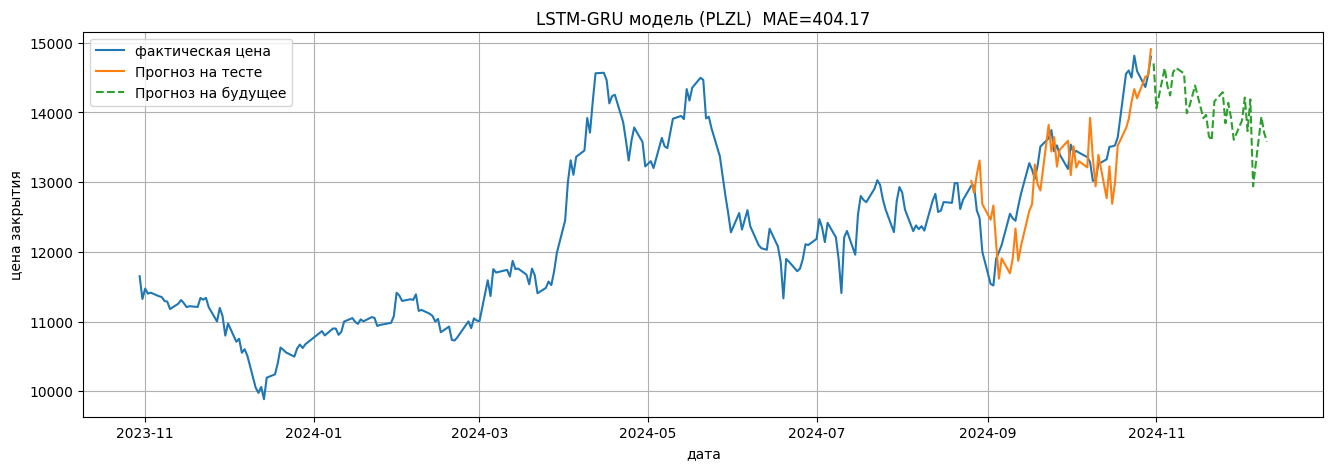

PLZL: "MSE":241112.9416743375,"MAE":404.16580870071675,"RMSE":491.0325260859381,"MAPE":0.031037463151285527,"R2":0.6339654837941449


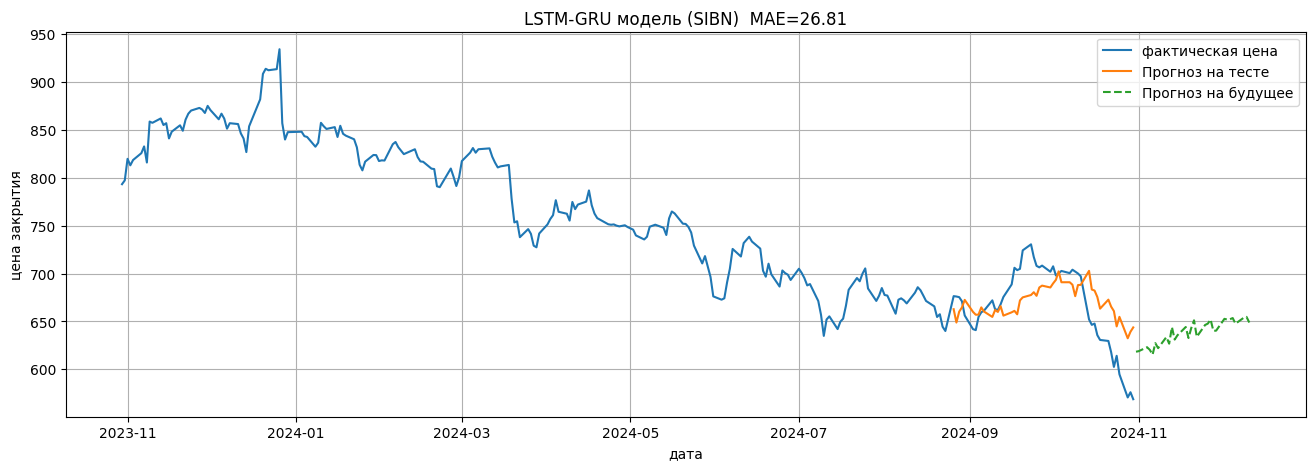

SIBN: "MSE":1094.0184496822649,"MAE":26.812980327052106,"RMSE":33.075949717011376,"MAPE":0.041280311104167,"R2":0.3436568206882512


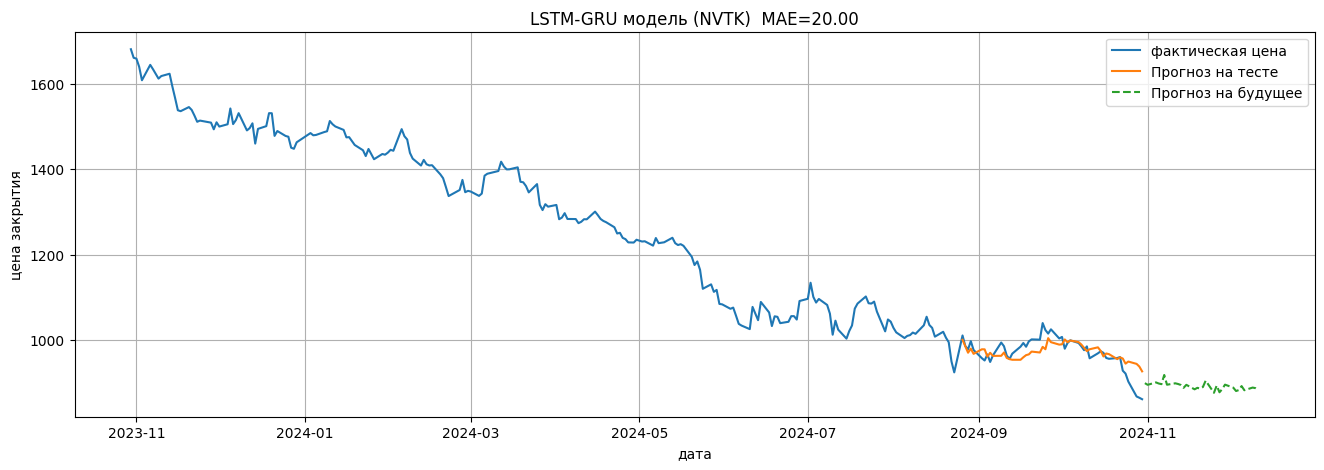

NVTK: "MSE":746.7791856286616,"MAE":20.003811103523006,"RMSE":27.327260851184146,"MAPE":0.02099666041743653,"R2":0.47835791551890394


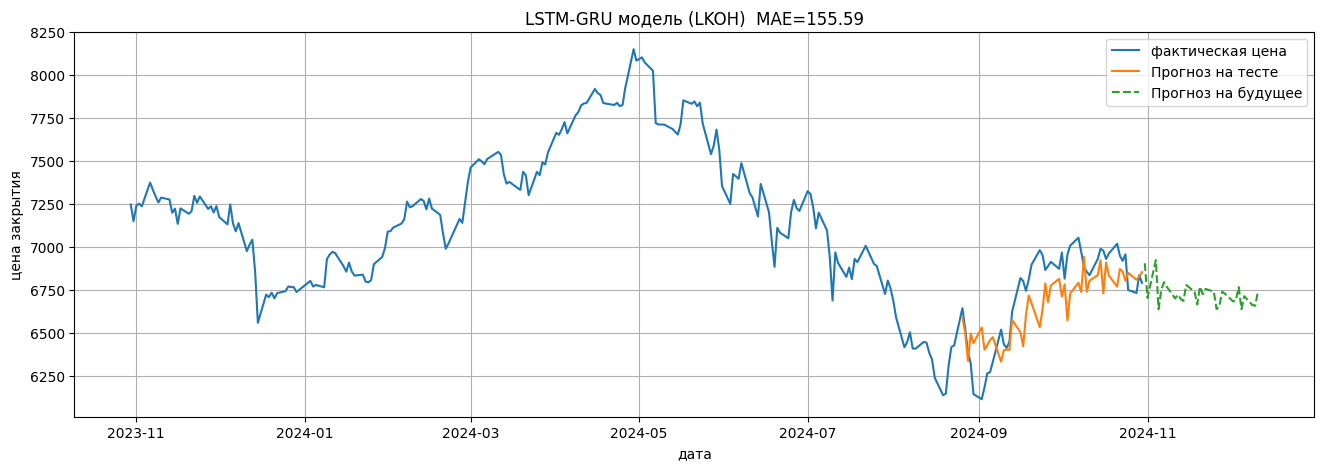

LKOH: "MSE":37676.107249641085,"MAE":155.58588127506673,"RMSE":194.1033416756164,"MAPE":0.02312162838527773,"R2":0.47229492234659876


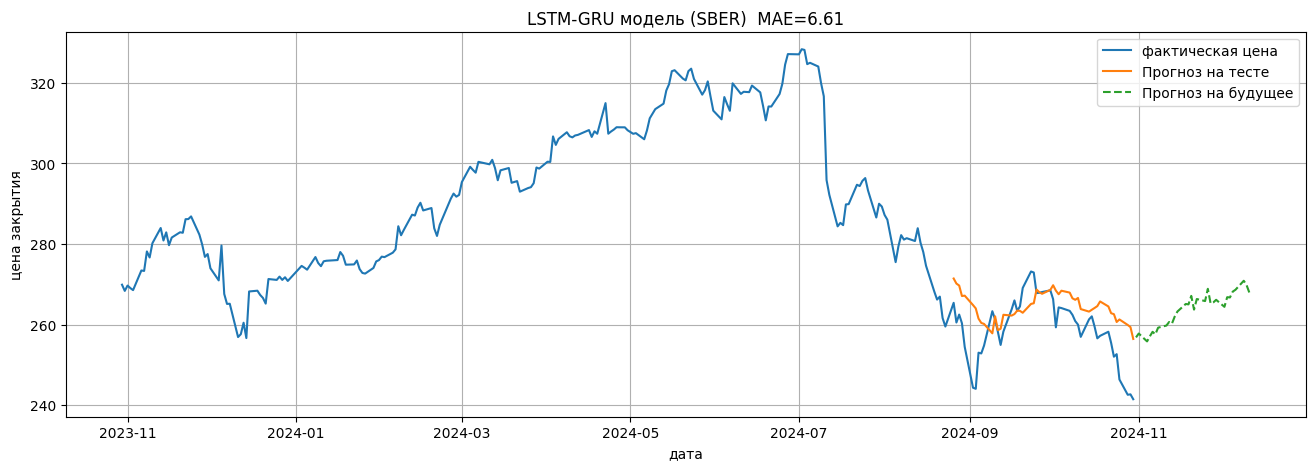

SBER: "MSE":69.78934247395962,"MAE":6.607790403717906,"RMSE":8.354001584507847,"MAPE":0.025999285398129884,"R2":-0.16555839050512344


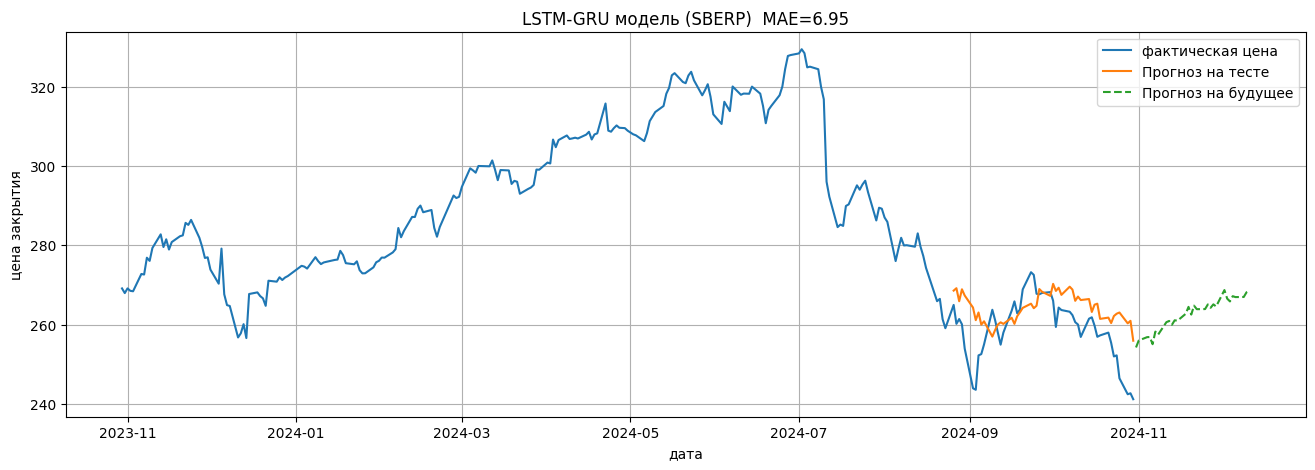

SBERP: "MSE":73.35436885809878,"MAE":6.946984424411615,"RMSE":8.564716507748448,"MAPE":0.027319644175186775,"R2":-0.2274459246793099


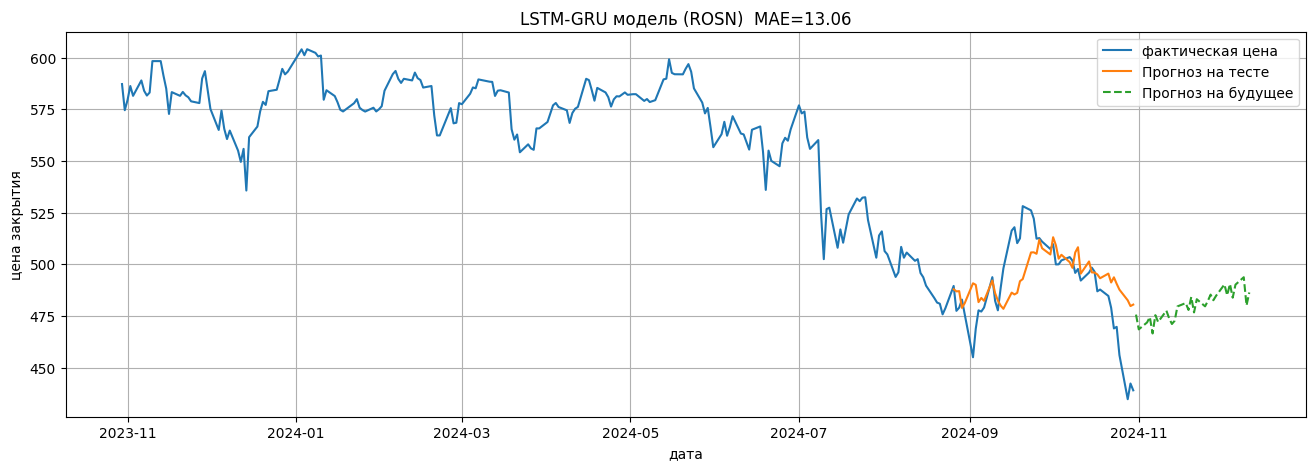

ROSN: "MSE":326.2380197511835,"MAE":13.060212559822775,"RMSE":18.062060229973312,"MAPE":0.027193159380330744,"R2":0.2959327744849971


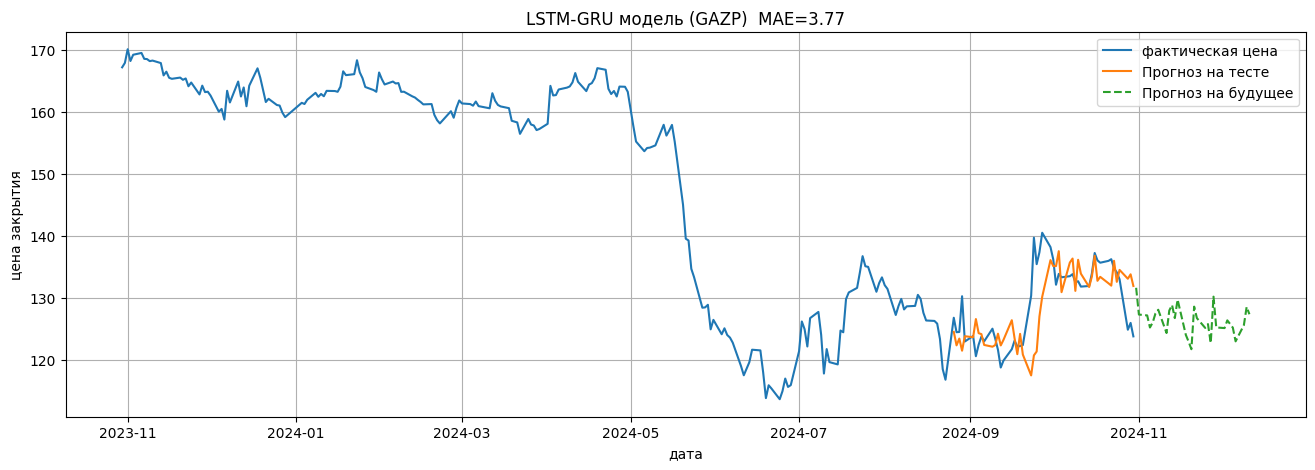

GAZP: "MSE":30.145111944985075,"MAE":3.767107297718551,"RMSE":5.49045644231744,"MAPE":0.028790389244604652,"R2":0.21523967531068933


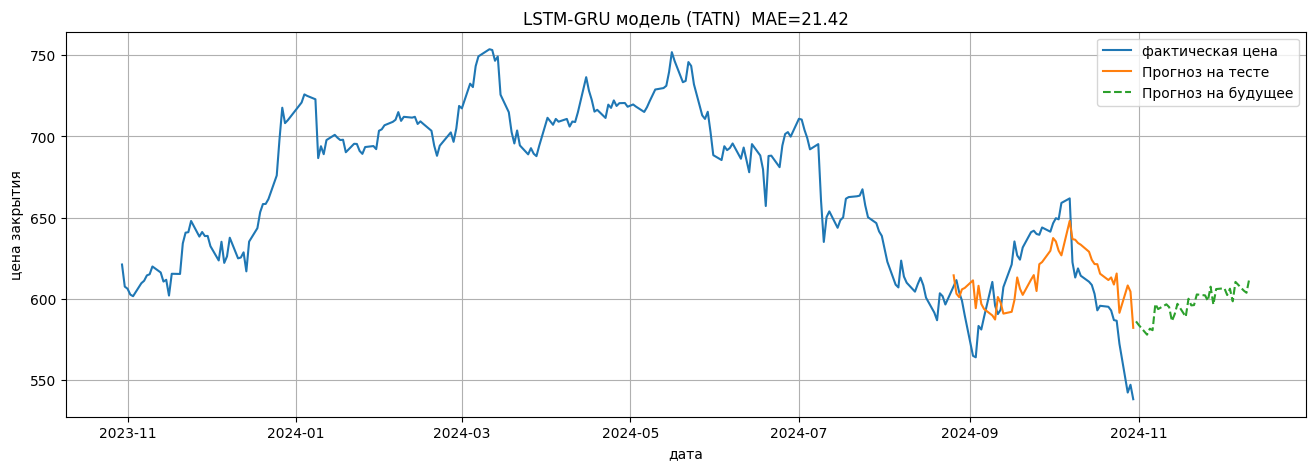

TATN: "MSE":621.852537441398,"MAE":21.420441678434447,"RMSE":24.936971296478607,"MAPE":0.03575117027981128,"R2":0.2891637462196609


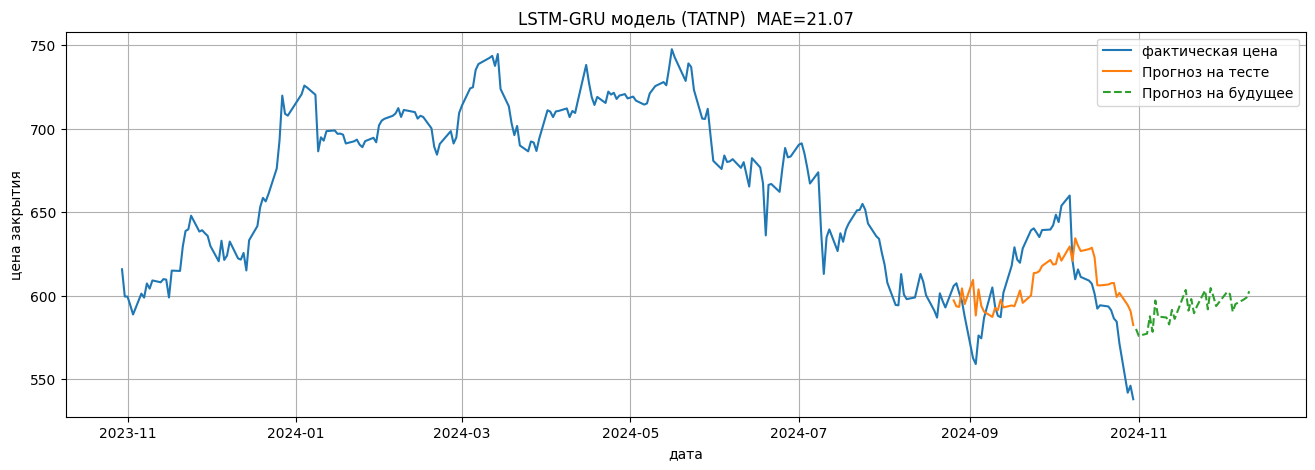

TATNP: "MSE":586.4916680242546,"MAE":21.069204914746276,"RMSE":24.21759005401352,"MAPE":0.03509320326475992,"R2":0.31177741754586885


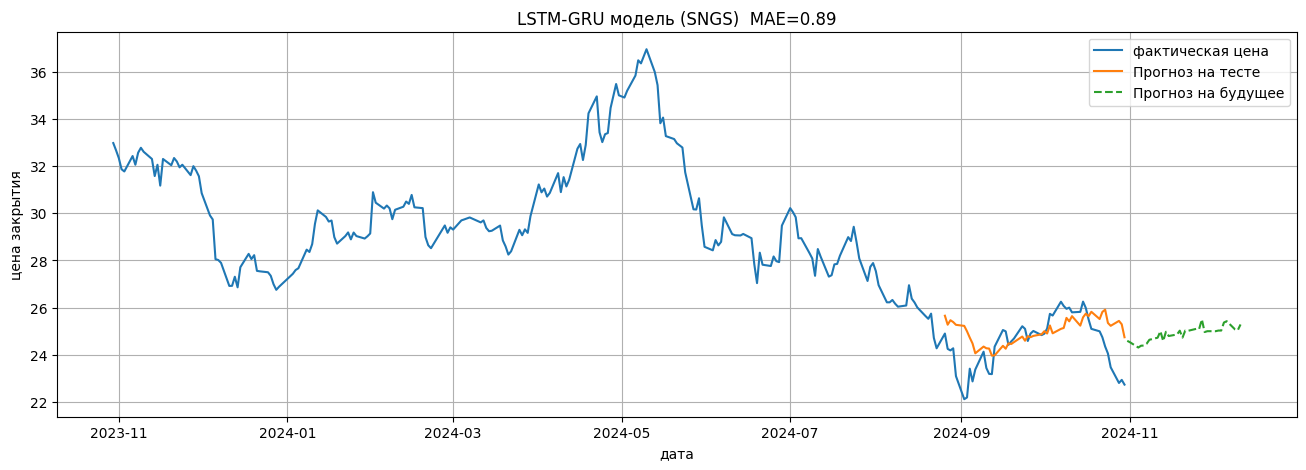

SNGS: "MSE":1.3738539177157778,"MAE":0.8912925819701759,"RMSE":1.1721151469526268,"MAPE":0.037494412355302896,"R2":-0.12510950516972286


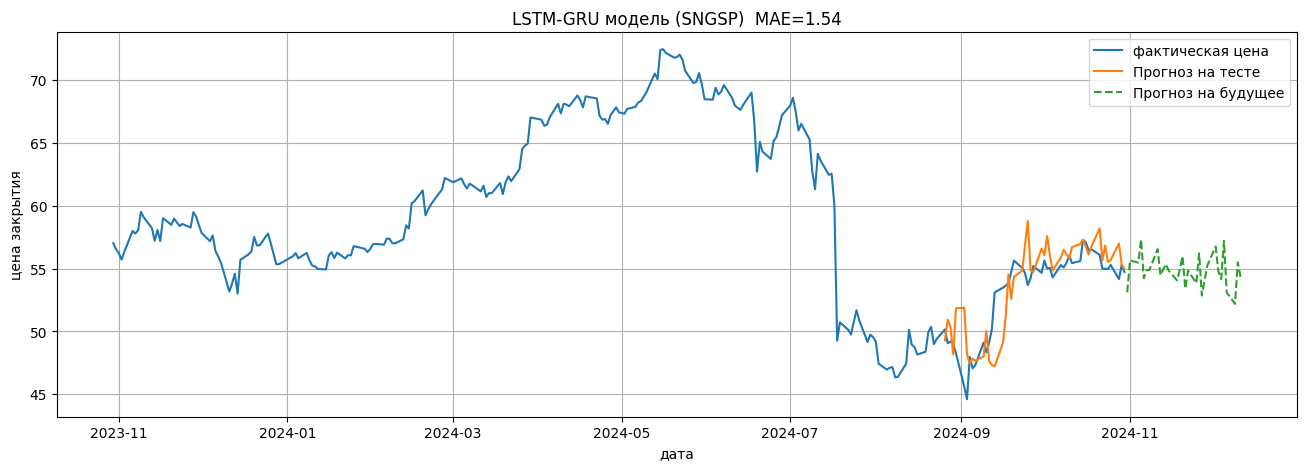

SNGSP: "MSE":4.573981782696393,"MAE":1.5397347568911417,"RMSE":2.138686929565988,"MAPE":0.029792350807449575,"R2":0.5862984999583755


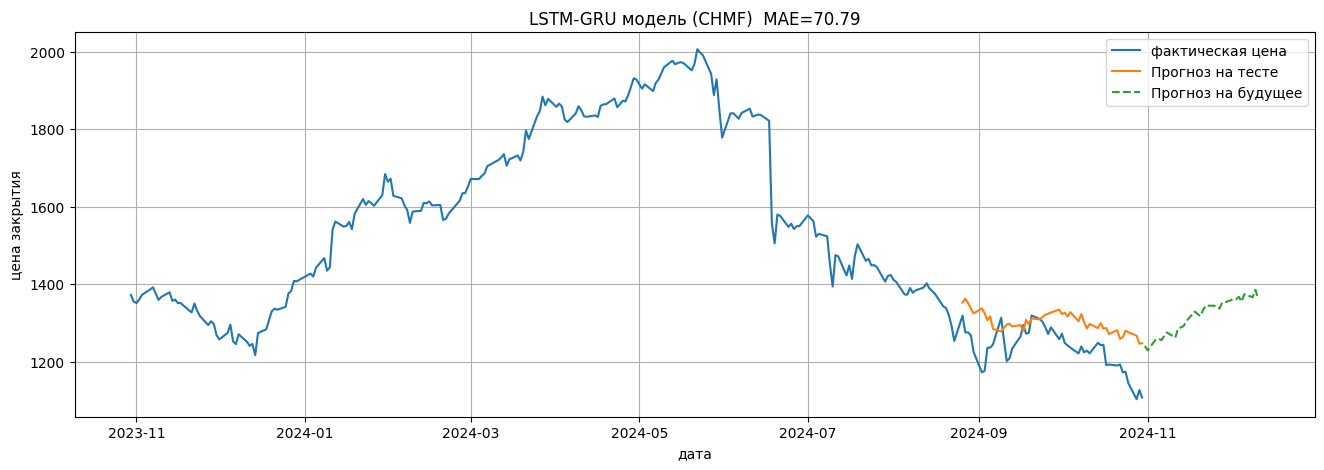

CHMF: "MSE":6502.483701796606,"MAE":70.78800277646747,"RMSE":80.63797927649604,"MAPE":0.05864839154360987,"R2":-1.3864048417631971


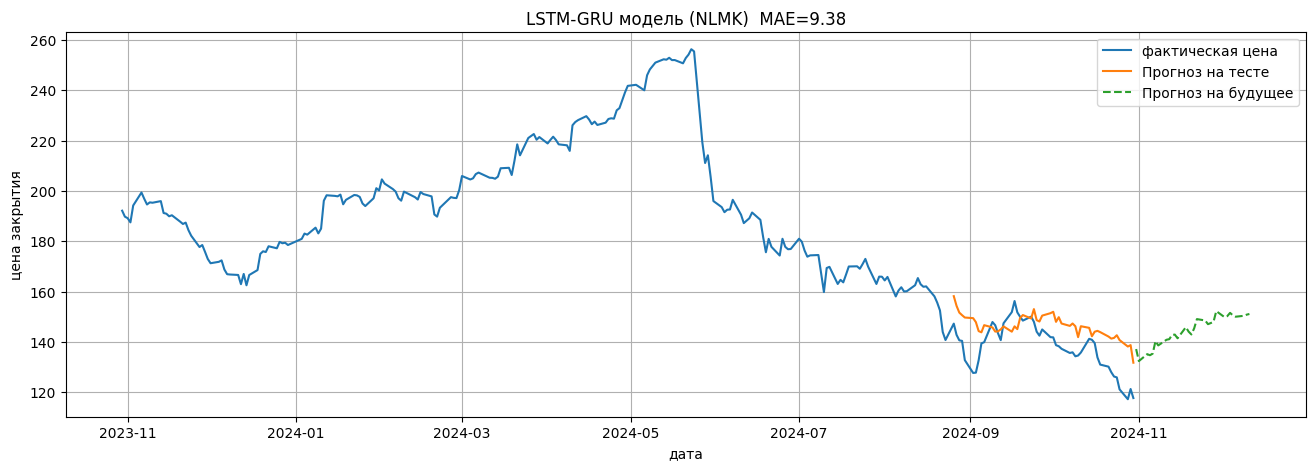

NLMK: "MSE":119.56040654271999,"MAE":9.38469516548389,"RMSE":10.934368136418309,"MAPE":0.07044237208119587,"R2":-0.42788393418011395


In [19]:
set_random_seed(seed=42)

results = {}
for tkr in first_tier_tickers:
    out = fit_once_lstm(data[data['TICKER'] == tkr], window=20,
                        future_forecast_days=30, epochs=100, verbose=0, noise_scale=0.4)
    results[tkr] = out

# Описание модели

В качестве DL подхода своего проекта мною была выбрна рекуррентная нейронная сеть RNN, использующая архитектуру **LSTM**  и **GRU**, так как они активно и часто используются для прогнозирования цен акций на основе исторических данных.

- **LSTM-GRU модель**: моя модель сочетает два типа рекуррентных слоёв - **LSTM** и **GRU**. Это позволяет ей улавливать как краткосрочные, так и долгосрочные зависимости в данных, что особенно важно для временных рядов, таких как данные о ценах на акции.
- **LSTM**: Этот слой помогает модели эффективно запоминать долгосрочные зависимости и решать проблему исчезающего градиента, что важно при обучении на длинных последовательностях.
- **GRU**: **GRU** является более лёгкой альтернативой **LSTM**, улучшая вычислительную эффективность, при этом сохраняет способность захватывать долгосрочные зависимости.

#### **Данные**:
- **Цена закрытия (CLOSE)**: Модель использует исторические данные о ценах закрытия акций. Данные очищаются от пропусков с помощью метода **forward fill**.
- **Волатильность**: Для улучшения прогноза добавляется дополнительный признак — волатильность, рассчитанная как стандартное отклонение цен закрытия за заданное окно (например, 20 дней). Это помогает модели учесть изменения в колебаниях цен, что особенно важно для высоковолатильных активов.
- **Данные о времени**: Каждая запись содержит информацию о дате сделки, которая используется для определения времени и тренда.

#### **Предобработка данных**:
- **Масштабирование**: Все данные (цены и волатильность) масштабируются с помощью **MinMaxScaler**, чтобы привести их к диапазону [0, 1]. Это важно для ускорения сходимости модели и улучшения её стабильности при обучении.
- **Заполнение пропусков**: Используется метод **forward fill** для заполнения пропущенных значений в столбце "CLOSE".

#### **Архитектура модели**:
- **LSTM слой**: Входной слой **LSTM** с 128 нейронами, который преобразует входные данные в последовательность признаков. Параметр **return_sequences=True** позволяет передавать выходные данные следующему слою.
- **Dropout**: Слой **Dropout(0.2)** используется для регуляризации модели, что помогает избежать переобучения, отключая случайные нейроны во время обучения.
- **GRU слой**: Далее применяется слой **GRU** с 64 нейронами, который помогает моделировать временные зависимости и снижает вычислительную нагрузку по сравнению с чистым **LSTM**.
- **Dropout**: Еще один слой **Dropout(0.2)** для предотвращения переобучения.
- **Dense слой**: Финальный полносвязный слой с 1 нейроном, который предсказывает цену закрытия акции на следующий день или через несколько дней.

#### **Обучение**:
- **Функция потерь**: Для обучения модели используется **Huber loss**. Эта функция потерь является более стабильной для наличия выбросов, что особенно полезно для данных о ценах акций.
- **Оптимизатор**: Для минимизации ошибки используется оптимизатор **Adam**, который является популярным и эффективным для задач машинного обучения.
- **EarlyStopping**: Для предотвращения переобучения добавлен callback **EarlyStopping**, который останавливает обучение, если модель не улучшает свою производительность в течение 10 эпох.

#### **Введение шума (волатильности)**:
Для того чтобы сделать прогноз более реалистичным и учитывать рыночные колебания, в модель добавляется **шум** на основе стандартного отклонения ошибок на тестовой выборке. Этот шум симулирует волатильность на рынке и добавляется к прогнозу на тестовой выборке и будущим прогнозам.

#### **Прогнозирование на будущее**:
Модель использует последние данные для создания прогноза на будущее, который затем корректируется добавлением **шумовых колебаний (волатильности)**.

Прогнозы на будущее создаются для заданного количества дней, и для этого модель обновляет окно данных после каждого предсказания.

#### **Оценка качества**:
Модель оценивается по **MSE** (Mean Squared Error), **MAE** (Mean Absolute Error), **RMSE** (Root Mean Squared Error), **MAPE** (Mean Absolute Percentage Error) и **R²** (коэффициент детерминации), которые помогают понять, насколько хорошо модель предсказывает фактические значения.

#### **другие особенности**:
- **Волатильность**: Включение волатильности в качестве дополнительного признака и добавление шума в прогнозы помогает модели лучше учитывать рыночные колебания и нестабильность, которые характерны для данных о ценах акций.
- **Обучение на тестах**: Модель обучается на исторических данных и проверяется на тестовых данных, после чего прогнозируются будущие значения с учётом волатильности.

# Результаты

In [21]:
models_metrics = {
    "LSTM-GRU": results
}

metrics_comparison = []
for model_name, results in models_metrics.items():
    for ticker, result in results.items():
        metrics_comparison.append({
            "Model": model_name,
            "Ticker": ticker,
            "MSE": result["MSE"],
            "MAE": result["MAE"],
            "RMSE": result["RMSE"],
            "MAPE": result["MAPE"],
            "R2": result["R2"]
        })

metrics_df = pd.DataFrame(metrics_comparison)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
metrics_df

,Model,Ticker,MSE,MAE,RMSE,MAPE,R2
0,LSTM-GRU,PLZL,241112.941674,404.165809,491.032526,0.031037,0.633965
1,LSTM-GRU,SIBN,1094.018450,26.812980,33.075950,0.041280,0.343657
2,LSTM-GRU,NVTK,746.779186,20.003811,27.327261,0.020997,0.478358
3,LSTM-GRU,LKOH,37676.107250,155.585881,194.103342,0.023122,0.472295
4,LSTM-GRU,SBER,69.789342,6.607790,8.354002,0.025999,-0.165558
5,LSTM-GRU,SBERP,73.354369,6.946984,8.564717,0.027320,-0.227446
6,LSTM-GRU,ROSN,326.238020,13.060213,18.062060,0.027193,0.295933
7,LSTM-GRU,GAZP,30.145112,3.767107,5.490456,0.028790,0.215240
8,LSTM-GRU,TATN,621.852537,21.420442,24.936971,0.035751,0.289164
9,LSTM-GRU,TATNP,586.491668,21.069205,24.217590,0.035093,0.311777


In [22]:
avg_metrics_df = metrics_df.groupby("Model", as_index=False).agg({
    "MSE": "mean",
    "MAE": "mean",
    "RMSE": "mean",
    "MAPE": "mean",
    "R2": "mean"
})

avg_metrics_df


,Model,MSE,MAE,RMSE,MAPE,R2
0,LSTM-GRU,20640.407825,54.431711,66.432002,0.035211,0.092449


- Лучшие результаты: Модель лучше всего работает с тикерами SNGS и TATNP, где ошибки минимальны и показатели R² высокие.

- Проблемные тикеры: Для PLZL и CHMF прогнозы имеют большие ошибки, что может быть связано с высокой волатильностью этих акций или недостаточными признаками.

# Сравнение с мл моделями и бейзлайном


| Model               | MSE        | MAE        | RMSE       | MAPE     | R²       |
|---------------------|------------|------------|------------|----------|----------|
| Decision Tree       | 13356.55   | 39.75      | 52.59      | 0.0199   | 0.3932   |
| **Exponential Smoothing**| 6142.96    | 27.29      | 35.40      | 0.0146   | 0.6235   |
| Gradient Boosting   | 7327.06    | 30.49      | 40.83      | 0.0174   | 0.5523   |
| LGBM                | 8035.96    | 33.18      | 44.51      | 0.0218   | 0.4149   |
| Random Forest       | 6907.29    | 29.26      | 38.40      | 0.0165   | 0.6357   |
| XGBoost             | 8567.84    | 31.50      | 42.18      | 0.0171   | 0.5694   |
| k-NN                | 12135.87   | 39.03      | 50.35      | 0.0230   | 0.2408   |
| LSTM-GRU            | 20640.41   | 54.43      | 66.43      | 0.0352   | 0.0924   |
| Lin Reg (Baseline)   | 5632.40    | 26.14      | 33.91      | 0.0156   | 0.7898   |


Результат ожидаемо хуже чем у мл моделей и бейзлайна, но это пока максимум, что я смог выжать из нее, хотя положительный р квадрат в среднем по тикерам все же радует))

возможно при должной настройке результат подойдет ближе к мл моделям и даже мб первзойдет его.  